## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
import math

In [9]:
import sys
import os

In [10]:
import functools

In [11]:
import torch
import torchvision

In [12]:
from einops import *

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
import networkx as nx

In [15]:
from pathlib import Path

In [16]:
import umap
#Note: VERY HACKY: Manually fixed broken deps install.
import umap.plot
from umap import UMAP

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [17]:
import glasbey

## Load our captures

In [18]:
df = pd.read_pickle('df_unified.pickle')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       80 non-null     object
 1   ymin       80 non-null     int64 
 2   ymax       80 non-null     int64 
 3   xmin       80 non-null     int64 
 4   xmax       80 non-null     int64 
 5   src        80 non-null     object
 6   tree_name  80 non-null     object
 7   crop       80 non-null     object
dtypes: int64(4), object(4)
memory usage: 5.1+ KB


In [18]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

bands_readable = {
    'wr': 'Wideband Red',
    'wg': 'Wideband Blue',
    'wb': 'Wideband Green',
    'r': 'Narrowband Red',
    'g': 'Narrowband Blue',
    'b': 'Narrowband Green',
    'nir': 'Near-Infrared',
    'red_edge': 'Red-Edge',
    'ndvi': 'NDVI'
}

## Produce the GLCM statistics

### Crop out the central 64x64 section?

This is actually skipped in the URECA paper.

### Perform binning

In [21]:
band_maxes = np.asarray([max([np.nanmax(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_maxes))

[255.0, 255.0, 255.0, 9078.422, 8151.5425, 4525.3228, 15971.092, 15825.321, 0.98923224]


In [22]:
band_mins = np.asarray([min([np.nanmin(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_mins))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3638862]


In [23]:
print([2**(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[256, 256, 256, 16384, 8192, 8192, 16384, 16384, 1]


In [24]:
divby = np.asarray([2, 2, 2, 128, 64, 64, 128, 128, 1])
divby

array([  2,   2,   2, 128,  64,  64, 128, 128,   1])

In [25]:
df_glcm = df.copy()
df_glcm['crop_binned'] = None
with torch.no_grad():
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        crop = row['crop'].copy()
        crop = np.nan_to_num(crop)
        crop /= divby
        crop[:,:,8] += 1
        crop[:,:,8] /= 2
        crop[:,:,8] *= 128
        #crop[:,:,9] -= 30
        #crop[:,:,9] /= (90-30)
        #crop[:,:,9] *= 127
        crop = np.clip(crop.astype('uint8'), 0, 127)
        df_glcm.at[idx,'crop_binned'] = crop

  0%|          | 0/80 [00:00<?, ?it/s]

### Visualise our binning results

In [26]:
crop_pre_binning = df_glcm['crop'].iloc[0]
crop_post_binning = df_glcm['crop_binned'].iloc[0]

Text(0, 0.5, 'after binning')

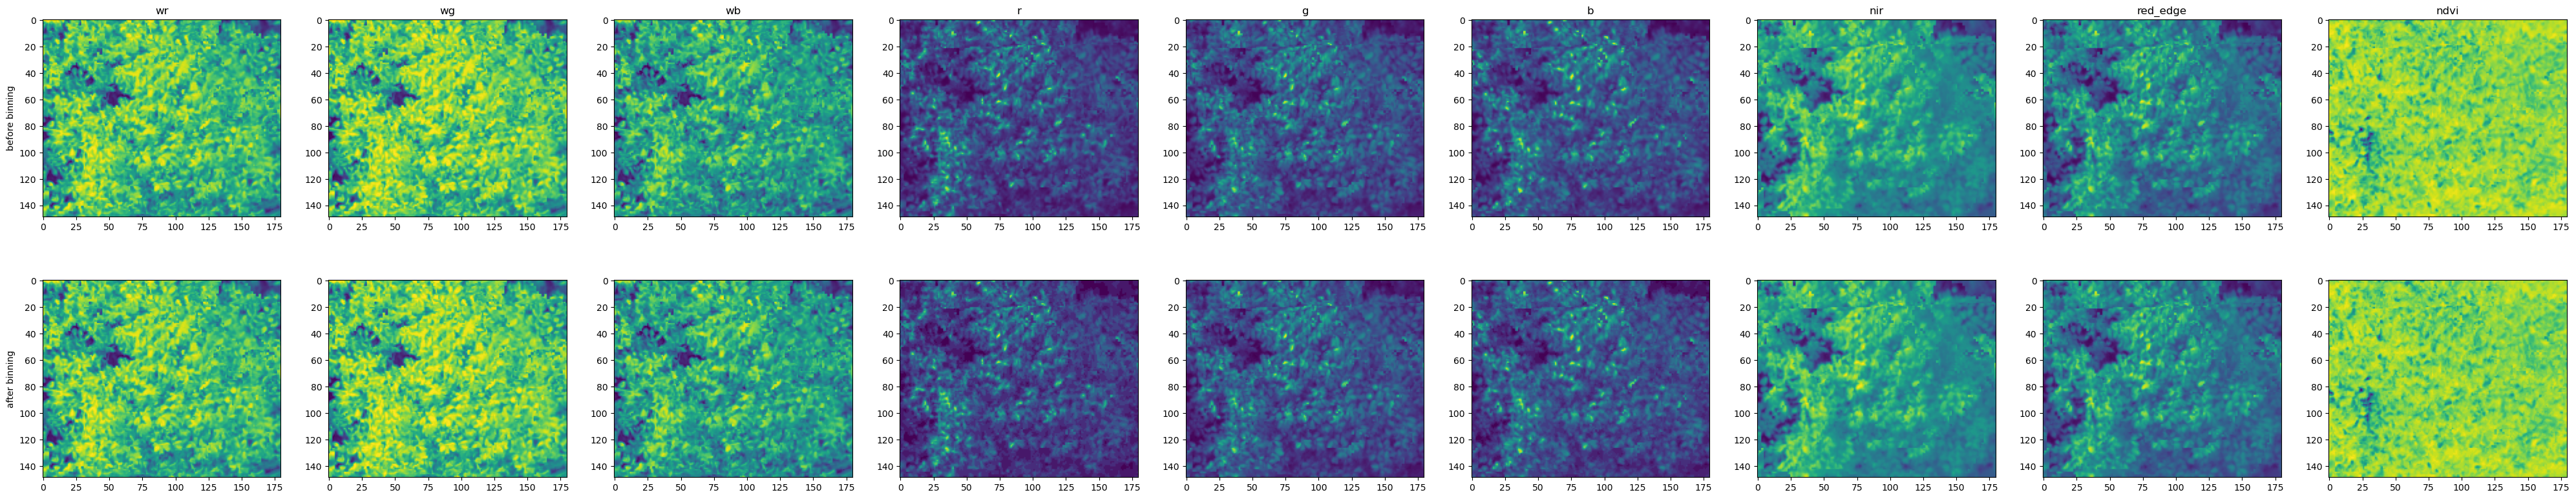

In [27]:
fig, ax = plt.subplots(n_rows := 2, n_cols := len(bands),
                       figsize=(5.6*n_cols, 4.8*n_rows))
for band, col_idx in zip(bands, range(n_cols)):
    ax[0,col_idx].imshow(crop_pre_binning[:,:,bands.index(band)])
    ax[1,col_idx].imshow(crop_post_binning[:,:,bands.index(band)])
    ax[0,col_idx].set_title(band)
ax[0,0].set_ylabel('before binning')
ax[1,0].set_ylabel('after binning')

In [28]:
band_maxes = np.asarray([max([np.nanmax(df_glcm['crop_binned'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_maxes))

[127, 127, 127, 70, 127, 70, 124, 123, 127]


### Produce random 32x32px ("M1 zoom level") crops

In [29]:
cropper = torchvision.transforms.RandomCrop(size=(32,32))

In [35]:
with torch.no_grad():
    df_glcm['m1_crops'] = df_glcm['crop_binned'].progress_apply(
        lambda x: [rearrange(cropper.forward(rearrange(torch.tensor(x), 'h w c -> c h w')), 'c h w -> h w c').numpy()
                   for i in range(64)])

  0%|          | 0/80 [00:00<?, ?it/s]

In [36]:
df_glcm = df_glcm.explode('m1_crops')

In [37]:
df_glcm = df_glcm.reset_index(drop=True)

In [41]:
df_glcm = df_glcm.drop('crop', axis=1)

In [42]:
df_glcm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         5120 non-null   object
 1   ymin         5120 non-null   int64 
 2   ymax         5120 non-null   int64 
 3   xmin         5120 non-null   int64 
 4   xmax         5120 non-null   int64 
 5   src          5120 non-null   object
 6   tree_name    5120 non-null   object
 7   crop_binned  5120 non-null   object
 8   m1_crops     5120 non-null   object
dtypes: int64(4), object(5)
memory usage: 360.1+ KB


A quick sanity check.

In [43]:
df_glcm['m1_crops'].apply(lambda x: x.shape).unique()

array([(32, 32, 9)], dtype=object)

In [44]:
df_glcm.to_pickle('df_glcm.pickle')

In [21]:
df_glcm = pd.read_pickle('df_glcm.pickle')

### Visualise our cropping+binning results

In [25]:
crop_1 = df_glcm['crop_binned'].iloc[0]
crop_1_m1_crops = df_glcm['m1_crops'].iloc[:4]

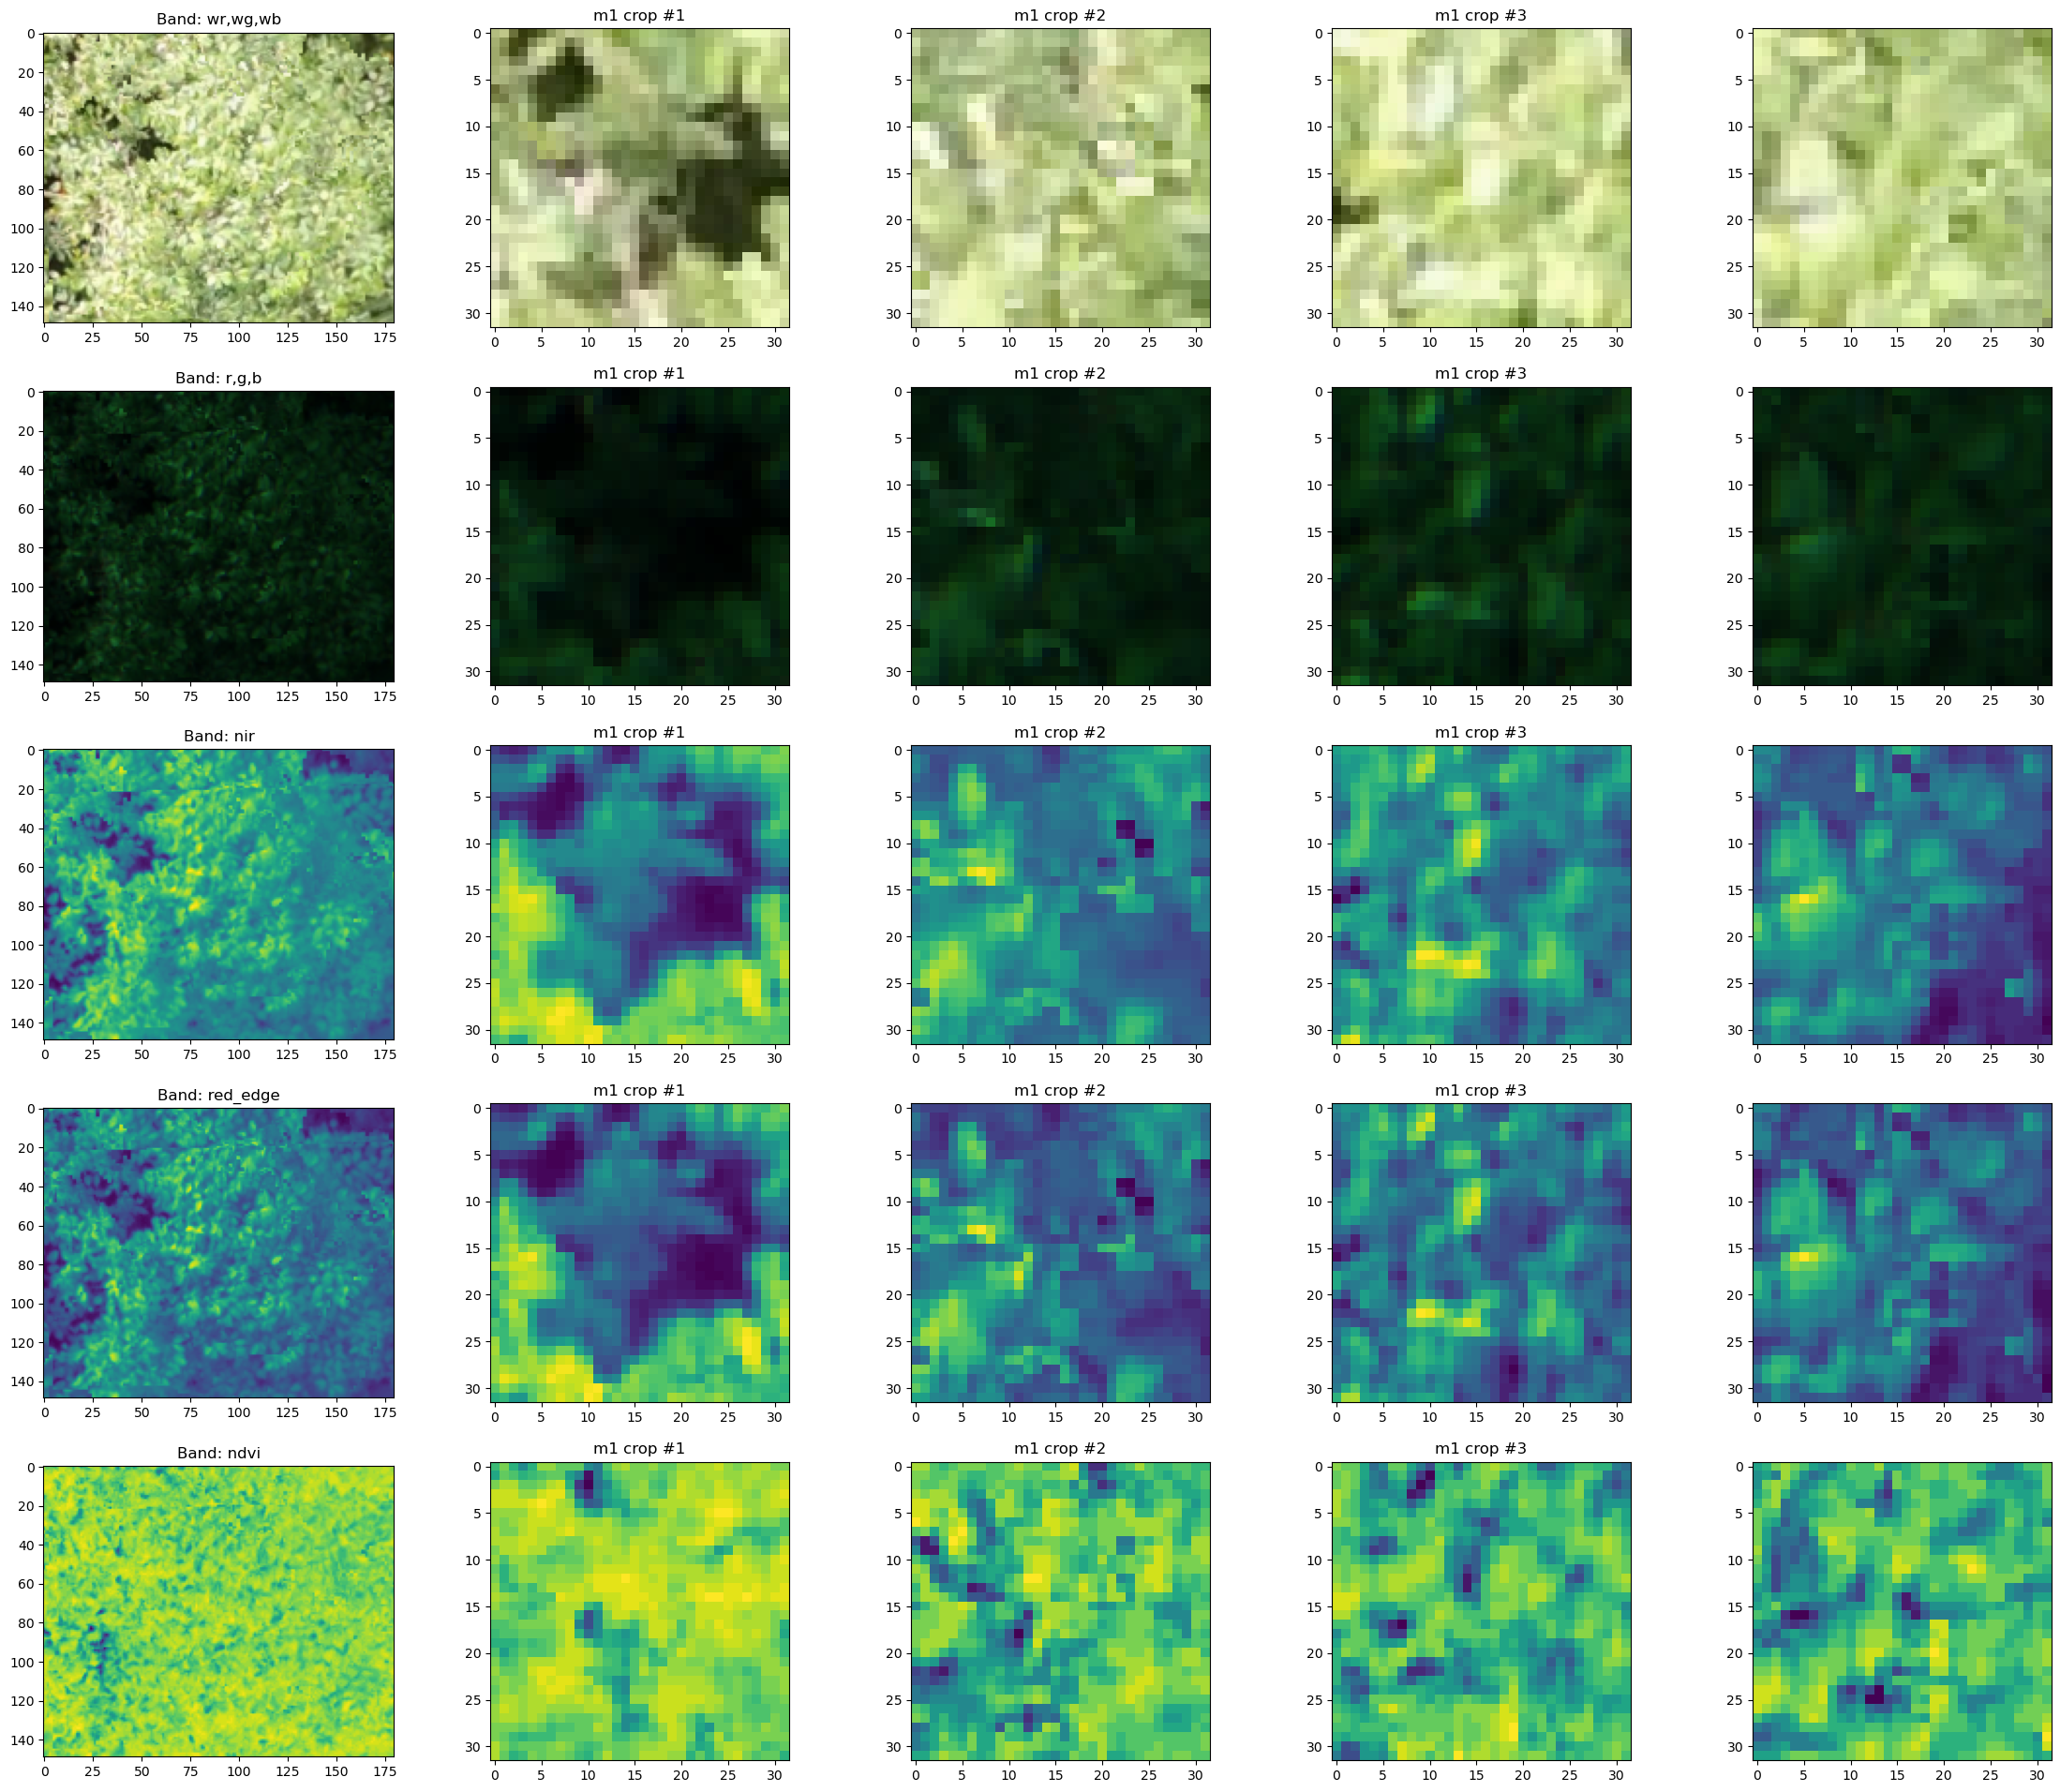

In [33]:
fig, ax = plt.subplots(5, 5, figsize=(5.6*5, 4.8*5))
for row, indexer, band_name in zip(ax,
                                   [slice(0,3), slice(3,6), 6, 7, 8],
                                   ['wr,wg,wb', 'r,g,b', *bands[-3:]]):
    row[0].imshow(crop_1[:,:,indexer] / 128)
    for m1_crop, box in zip(crop_1_m1_crops, row.flatten()[1:]):
        box.imshow(m1_crop[:,:,indexer] / 128)
    row[0].set_title('Band: {}'.format(band_name))
    for box, title in zip(row[1:],
                          ['m1 crop #{}'.format(i) for i in [1, 2, 3]]):
        box.set_title(title)

### Add random noise to each random crop

In [34]:
def noise_image(arr):
    noise = np.random.choice([0, 1], size=arr.shape, replace=True, p=[0.2, 0.8])
    return np.where(noise, arr, 128)

In [35]:
df_glcm['m1_noised_crops'] = df_glcm['m1_crops'].progress_apply(noise_image)

  0%|          | 0/5120 [00:00<?, ?it/s]

In [36]:
df_glcm.to_pickle('df_glcm.pickle')

In [19]:
df_glcm = pd.read_pickle('df_glcm.pickle')

### Produce the GLCM-property features

In [20]:
def parallel_glcm_props(crop):
    import numpy as np
    import skimage
    from skimage.feature import graycomatrix
    from skimage.feature import graycoprops
    from math import pi
    
    distances = [1]
    angles = [0, 0.25*pi, 0.5*pi, 0.75*pi, pi, 1.25*pi, 1.5*pi, 1.75*pi]
    levels = 129
    symmetric = False
    normed = True
    
    def glcms_from_crop(crop):
        glcms = np.stack([graycomatrix(crop[:,:,i], distances=distances, angles=angles,
                                  levels=levels, symmetric=symmetric, normed=False)
                     for i in range(crop.shape[-1])], axis=-1)[:128,:128]
        if normed:
            return norm(glcms)
        else:
            return glcms
    
    def norm(glcms):
        return glcms / np.sum(glcms, axis=(0,1,2,3), keepdims=True)
    
    def graycomean(glcm):
        return np.sum(glcm.T * np.arange(glcm.shape[0]))
    
    def graycovar(glcm, mean):
        return np.sum(glcm.T * np.square(np.arange(glcm.shape[0]) - mean)) 
    
    bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']
    props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    
    def graycoprops_from_glcms(glcms, crop):
        new_dict = {}
        for band in bands:
            new_dict[(band, 'mean_no_glcm')] = np.mean(crop[:,:,bands.index(band)])
            if band in ['ndvi', 'chm']:
                continue
            mean = graycomean(glcms[:,:,:,:,bands.index(band)])
            new_dict[(band, 'mean')] = mean
            new_dict[(band, 'var')] = graycovar(glcms[:,:,:,:,bands.index(band)], mean)
            for prop in props[3:]:             
                new_dict[(band, prop)] = graycoprops(glcms[:,:,:,:,bands.index(band)], prop).mean()
        return new_dict

    return graycoprops_from_glcms(glcms_from_crop(crop), crop)

In [21]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=5)
df_glcm['props'] = df_glcm['m1_noised_crops'].parallel_apply(parallel_glcm_props)

In [23]:
df_glcm.to_pickle('df_glcm.pickle')

### Tidy up the dataframe

In [24]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [25]:
df_glcm_new = pd.DataFrame(index=df_glcm.index)

In [26]:
df_glcm_new = pd.concat((df_glcm, df_glcm['props'].progress_apply(pd.Series)), axis=1)

  0%|          | 0/5120 [00:00<?, ?it/s]

In [31]:
df_glcm = df_glcm_new

In [32]:
df_glcm.to_pickle('df_glcm.pickle')